In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline
from nflows.transforms.dequantization import UniformDequantization
from nflows.transforms.dequantization import VariationalDequantization

In [4]:
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform

In [5]:
# Generate some dist with 2 real and 2 discrete dims

# These are the probabilities to draw a particular label
x_prob_1 = np.random.rand(10)
x_prob_2 = np.random.rand(5)
p_labels_1 = x_prob_1/(np.sum(x_prob_1))
p_labels_2 = x_prob_2/(np.sum(x_prob_2))
p_cum_labels_1 = np.cumsum(p_labels_1)
p_cum_labels_2 = np.cumsum(p_labels_2)

def p(x,y):
    if np.all(x > 0) and np.all(x < 1) and x.shape == y.shape:
        return m.exp(-(x[0] + x[1])/2) * np.cos((x[0]*y[0] + x[1]*y[1])*m.pi)
    return 0

def generate(n):
    x = np.zeros((n,4))

    counter = 0
    while(counter < n):
        y = np.zeros(2)
        y[0] = np.argmax(r.random() < p_cum_labels_1)
        y[1] = np.argmax(r.random() < p_cum_labels_2)

        while(True):
            # Get a point
            x_trial = np.random.rand(2)
            if r.random() < p(x_trial, y):
                x[counter][0] = x_trial[0]
                x[counter][1] = x_trial[1]
                x[counter][2] = y[0]
                x[counter][3] = y[1]
                counter += 1
                break

    return x

In [6]:
vardeq = VariationalDequantization(max_labels=torch.tensor([-1,-1,9,4]), rqs_hidden_features=15, rqs_flow_layers=5)
unideq = UniformDequantization(max_labels=torch.tensor([-1,-1,9,4]))

In [7]:
'''
x_plot = generate(1000000)
x_select_1 = x_plot[x_plot[:,2] == 7]
x_select_2 = x_select_1[x_select_1[:,3] == 3]
plt.hist2d(x_select_2[:,0], x_select_2[:,1], bins=25)
plt.show()
'''

'\nx_plot = generate(1000000)\nx_select_1 = x_plot[x_plot[:,2] == 7]\nx_select_2 = x_select_1[x_select_1[:,3] == 3]\nplt.hist2d(x_select_2[:,0], x_select_2[:,1], bins=25)\nplt.show()\n'

In [8]:
num_layers = 5
base_dist = BoxUniform(torch.zeros(4), torch.ones(4))

transforms = []
transforms.append(VariationalDequantization(max_labels=torch.tensor([-1,-1,9,4]), rqs_hidden_features=15, rqs_flow_layers=2))
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=4))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=4, 
        hidden_features=25,
        num_bins=25,
        num_blocks=4,
    ))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [9]:
num_iter = 1500
batch_size = 500
for i in range(num_iter):
    x = generate(batch_size)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i % 50 == 0):
        print(loss.item())

1.2072983980178833
-0.022299079224467278
-0.23004011809825897
-0.3646541237831116
-0.32048699259757996
-0.3653544783592224
-0.4067375063896179
-0.46315693855285645
-0.43288275599479675
-0.42260488867759705
-0.49140968918800354
-0.4055134952068329
-0.5276866555213928
-0.5176669359207153
-0.4144808053970337
-0.4920062720775604
-0.5408554077148438
-0.4174027442932129
-0.5588931441307068
-0.4608205556869507
-0.48117563128471375
-0.5482895970344543
-0.5485855937004089
-0.6176819205284119
-0.6781929135322571
-0.6695135831832886
-0.6248233318328857
-0.5856252908706665
-0.7028559446334839
-0.628689169883728


In [12]:
n_events = 100000
x_truth = generate(n_events)
with torch.no_grad():
    x_flow = flow.sample(n_events).numpy()

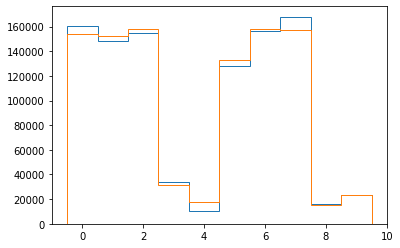

In [13]:
plt.hist(x_truth[:,2], histtype="step", bins = np.linspace(-0.5, 9.5, num=11))
plt.hist(x_flow[:,2], histtype="step", bins = np.linspace(-0.5, 9.5, num=11))
plt.show()